In [1]:
from xgboost import DMatrix

from mafaulda_preprocessing import *
from mafaulda_xgboost import *
from mafaulda_metrics import *

In [2]:
# ========================
# --- data importation ---
# ========================

CSV_FILE = 'data/mafaulda_main_classes_24khz_500ms_20ms_40-mfcc.csv'

FEATURES = [
    'mfcc_1',
    'mfcc_2',
    'mfcc_3',
    'mfcc_4',
    'mfcc_5',
    'mfcc_6',
    'mfcc_7',
    'mfcc_8'
]

df = data_reading(
    csv_file = CSV_FILE,
    features_columns = FEATURES
)

In [3]:
# ========================
# --- data preparation ---
# ========================

N_SAMPLES       = 6000
RANDOM_STATE    = 42

sampling_strategy = {i: N_SAMPLES for i in range(6)}

df = data_preparation(
    df                  = data_cleaning(df),
    columns_to_drop     = ['filename', 'class', 'label', 'source'],
    sampling_strategy   = sampling_strategy,
    scaling_method      = 'RobustScaler',
    random_state        = RANDOM_STATE
)

X_train, y_train, X_test, y_test = data_splitting(
    df,
    test_size       = 0.20,
    random_state    = RANDOM_STATE
)

dtrain  = DMatrix(X_train, label=y_train)
dtest   = DMatrix(X_test, label=y_test)

Fold 1 --> accuracy: 0.9408, precision: 0.9421, recall: 0.9412, f1: 0.9416, fbeta: 0.9414
Fold 2 --> accuracy: 0.9508, precision: 0.9512, recall: 0.9516, f1: 0.9514, fbeta: 0.9515
Fold 3 --> accuracy: 0.9477, precision: 0.9484, recall: 0.9482, f1: 0.9482, fbeta: 0.9482
Fold 4 --> accuracy: 0.9438, precision: 0.9449, recall: 0.9445, f1: 0.9446, fbeta: 0.9446
Fold 5 --> accuracy: 0.9453, precision: 0.9465, recall: 0.9456, f1: 0.9460, fbeta: 0.9458

Accuracy:       0.9457 ± 0.0034
Precision:      0.9466 ± 0.0031
Recall:         0.9463 ± 0.0035
F-1 Score:      0.9464 ± 0.0033
F-Beta Score:   0.9463 ± 0.0034


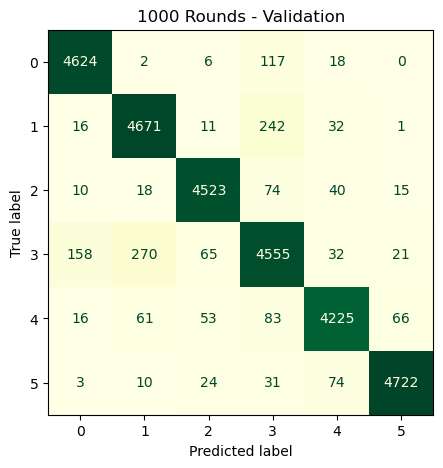

In [4]:
# ======================
# --- model training ---
# ======================

N_ROUNDS    = 1000  # number of trees (rounds) of boosting
MAX_DEPTH   = 5     # max depth for each tree

model,          \
y_valid_all,    \
y_pred_all,     \
accuracy_list,  \
precision_list, \
recall_list,    \
f1_list,        \
fbeta_list = xgboost_train(
    X_train             = X_train,
    y_train             = y_train,
    n_rounds            = N_ROUNDS,
    params              = {'max_depth': MAX_DEPTH},
    save_model          = False,
    print_fold_metrics  = True,
    print_full_metrics  = True
)

# Ploting Confusion Matrix
plot_confusion_matrix(
    y_true                  = y_valid_all,
    y_pred                  = y_pred_all,
    figure_title            = f'{N_ROUNDS} Rounds - Validation',
    save_figure             = False,
    save_figure_filename    = f'Mafaulda_Confusion_Matrix_rounds={N_ROUNDS}_validation'
)

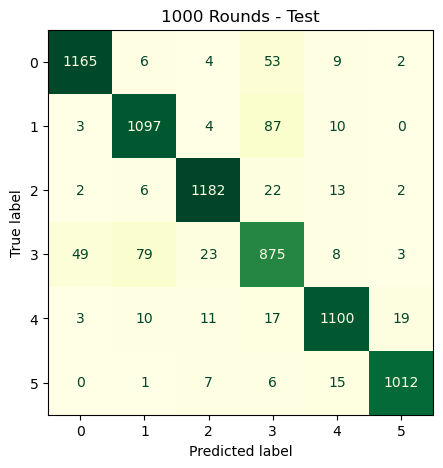

In [5]:
# ========================
# --- model assessment ---
# ========================

y_pred = xgboost_predict(model=model, dtest=dtest)

plot_confusion_matrix(
    y_true                  = y_test,
    y_pred                  = y_pred,
    cmap                    = 'YlGn',
    figure_title            = f'{N_ROUNDS} Rounds - Test',
    save_figure             = False,
    save_figure_filename    = f'Mafaulda_Confusion_Matrix_rounds={N_ROUNDS}_test'
)

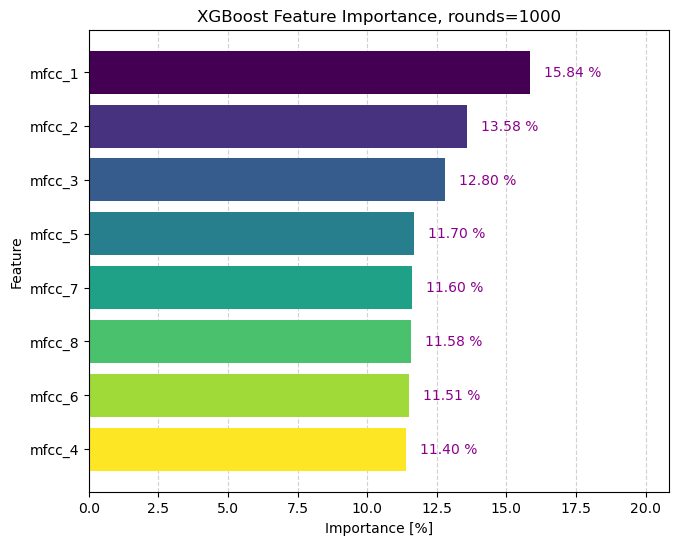

In [6]:
# ==========================
# --- Feature Importance ---
# ==========================

plot_feature_importance(
    model = model,
    df = df,
    features_columns = FEATURES,
    title = f'XGBoost Feature Importance, rounds={N_ROUNDS}',
    figsize = (8, 6),
    cmap = 'viridis',
    reverse_cmap = True,
    save_figure = True,
    save_figure_filename='Feature_Importance',
    importance_type = 'weight', # 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
    importance_sorting_ascending = False,
    n_top_features = None
)

In [7]:
# ========================
# --- XGBoost Sweeping ---
# ========================

MIN_ROUNDS  = 100
MAX_ROUNDS  = 2000
STEP_ROUNDS = 100

accuracy_list,  \
precision_list, \
recall_list,    \
f1_list,        \
fbeta_list,     \
y_valid_all,    \
y_pred_all = xgboost_train_sweeping(
    X_train             = X_train,
    y_train             = y_train,
    min_rounds          = MIN_ROUNDS,
    max_rounds          = MAX_ROUNDS,
    step_rounds         = STEP_ROUNDS,
    max_depth           = 5,
    print_fold_metrics  = False,
    print_full_metrics  = False,
    verbose             = True
)

np.savez(f'xgboost_results_from={MIN_ROUNDS}_to={MAX_ROUNDS}_maxdepth={MAX_DEPTH}.npz',
    accuracy    = np.array(accuracy_list),
    precision   = np.array(precision_list),
    recall      = np.array(recall_list),
    f1          = np.array(f1_list),
    fbeta       = np.array(fbeta_list),
    y_valid     = np.array(y_valid_all),
    y_pred      = np.array(y_pred_all)
)

Number of estimators:   100 ...


Number of estimators:   200 ...
Number of estimators:   300 ...
Number of estimators:   400 ...
Number of estimators:   500 ...
Number of estimators:   600 ...
Number of estimators:   700 ...
Number of estimators:   800 ...
Number of estimators:   900 ...
Number of estimators:  1000 ...
Number of estimators:  1100 ...
Number of estimators:  1200 ...
Number of estimators:  1300 ...
Number of estimators:  1400 ...
Number of estimators:  1500 ...
Number of estimators:  1600 ...
Number of estimators:  1700 ...
Number of estimators:  1800 ...
Number of estimators:  1900 ...
Number of estimators:  2000 ...


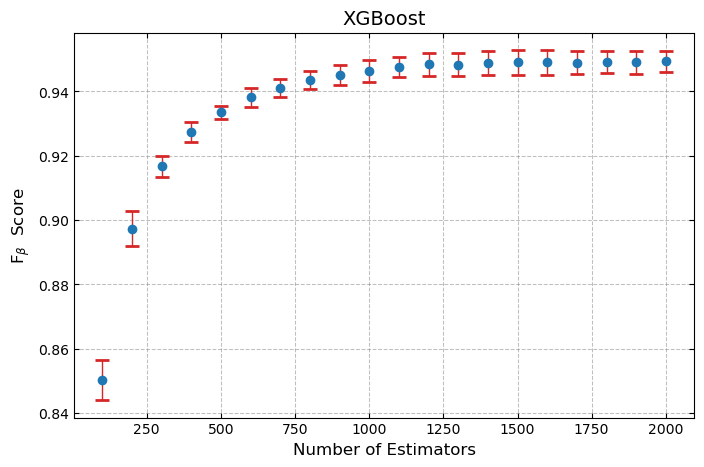

In [8]:
data = np.load('xgboost_results_from=100_to=2000_maxdepth=5.npz')

accuracy    = data['accuracy']
precision   = data['precision']
recall      = data['recall']
f1          = data['f1']
fbeta       = data['fbeta']

plot_xgboost_sweep(
    min_rounds              = MIN_ROUNDS,
    max_rounds              = MAX_ROUNDS,
    step_rounds             = STEP_ROUNDS,
    metric_values           = fbeta,
    title                   = 'XGBoost',
    x_label                 = 'Number of Estimators',
    y_label                 = r'F$_{\beta}\ $ Score',
    save_figure             = True,
    save_figure_filename    = 'XGBoost_Sweeping'
)